In [1]:
from IPython.display import clear_output

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

/cis/home/rmuthuk1/anaconda3/envs/advrob/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
assert torch.cuda.is_available()
cuda = torch.device('cuda')

In [4]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import os, glob
from torchvision.io import read_image, ImageReadMode


In [5]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -q tiny-imagenet-200.zip

--2024-04-14 16:40:03--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.64.64
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs231n.stanford.edu/tiny-imagenet-200.zip [following]
--2024-04-14 16:40:03--  https://cs231n.stanford.edu/tiny-imagenet-200.zip
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  9.65MB/s    in 26s     

2024-04-14 16:40:30 (8.95 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [6]:
batch_size = 64

id_dict = {}
for i, line in enumerate(open('./tiny-imagenet-200/wnids.txt', 'r')):
    id_dict[line.replace('\n', '')] = i

In [79]:
id_dict.keys()

dict_keys(['n02124075', 'n04067472', 'n04540053', 'n04099969', 'n07749582', 'n01641577', 'n02802426', 'n09246464', 'n07920052', 'n03970156', 'n03891332', 'n02106662', 'n03201208', 'n02279972', 'n02132136', 'n04146614', 'n07873807', 'n02364673', 'n04507155', 'n03854065', 'n03838899', 'n03733131', 'n01443537', 'n07875152', 'n03544143', 'n09428293', 'n03085013', 'n02437312', 'n07614500', 'n03804744', 'n04265275', 'n02963159', 'n02486410', 'n01944390', 'n09256479', 'n02058221', 'n04275548', 'n02321529', 'n02769748', 'n02099712', 'n07695742', 'n02056570', 'n02281406', 'n01774750', 'n02509815', 'n03983396', 'n07753592', 'n04254777', 'n02233338', 'n04008634', 'n02823428', 'n02236044', 'n03393912', 'n07583066', 'n04074963', 'n01629819', 'n09332890', 'n02481823', 'n03902125', 'n03404251', 'n09193705', 'n03637318', 'n04456115', 'n02666196', 'n03796401', 'n02795169', 'n02123045', 'n01855672', 'n01882714', 'n02917067', 'n02988304', 'n04398044', 'n02843684', 'n02423022', 'n02669723', 'n04465501', '

In [82]:
label_dict = {}
for i, line in enumerate(open('./tiny-imagenet-200/words.txt', 'r')):
    line = line.replace('\n', '')
    n_id, word = line.split('\t')[:2]
    if n_id in id_dict.keys():
        label_id = id_dict[n_id]
        print(line)
        print('n_id is ' + str(n_id))
        print('word is ' + word)
        print('label id is  ' + str(label_id))
        label_dict[label_id] = word
        

n01443537	goldfish, Carassius auratus
n_id is n01443537
word is goldfish, Carassius auratus
label id is  22
n01629819	European fire salamander, Salamandra salamandra
n_id is n01629819
word is European fire salamander, Salamandra salamandra
label id is  55
n01641577	bullfrog, Rana catesbeiana
n_id is n01641577
word is bullfrog, Rana catesbeiana
label id is  5
n01644900	tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui
n_id is n01644900
word is tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui
label id is  183
n01698640	American alligator, Alligator mississipiensis
n_id is n01698640
word is American alligator, Alligator mississipiensis
label id is  160
n01742172	boa constrictor, Constrictor constrictor
n_id is n01742172
word is boa constrictor, Constrictor constrictor
label id is  177
n01768244	trilobite
n_id is n01768244
word is trilobite
label id is  174
n01770393	scorpion
n_id is n01770393
word is scorpion
label id is  125
n01774384	black widow, Latrodectus

In [85]:
label_dict[91]

'iPod'

In [8]:
id_dict['n02124075']

0

In [38]:
class TrainTinyImageNetDataset(Dataset):
    def __init__(self, id, transform=None):
        self.filenames = glob.glob("./tiny-imagenet-200/train/*/*/*.JPEG")
        self.transform = transform
        self.id_dict = id

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_path = self.filenames[idx]
        image = read_image(img_path)
        if image.shape[0] == 1:
            image = read_image(img_path,ImageReadMode.RGB)
        #print(img_path)
        #k = img_path.split('/')[5]
        #print(k)
        #print(k.split('_')[0])
        label = self.id_dict[img_path.split('/')[5].split('_')[0]]
        if self.transform:
            image = self.transform(image.type(torch.FloatTensor))
        return image, label


In [39]:
class TestTinyImageNetDataset(Dataset):
    def __init__(self, id, transform=None):
        self.filenames = glob.glob("./tiny-imagenet-200/val/images/*.JPEG")
        self.transform = transform
        self.id_dict = id
        self.cls_dic = {}
        for i, line in enumerate(open('./tiny-imagenet-200/val/val_annotations.txt', 'r')):
            a = line.split('\t')
            img, cls_id = a[0],a[1]
            self.cls_dic[img] = self.id_dict[cls_id]


    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_path = self.filenames[idx]
        image = read_image(img_path)
        if image.shape[0] == 1:
            image = read_image(img_path,ImageReadMode.RGB)
        label = self.cls_dic[img_path.split('/')[-1]]
        if self.transform:
            image = self.transform(image.type(torch.FloatTensor))
        return image, label

In [40]:
#loads images as 3*64*64 tensors 
transform = transforms.Normalize((122.4786, 114.2755, 101.3963), (70.4924, 68.5679, 71.8127))

trainset = TrainTinyImageNetDataset(id=id_dict, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = TestTinyImageNetDataset(id=id_dict, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [65]:
means = [122.4786, 114.2755, 101.3963]
std = (70.4924, 68.5679, 71.8127)
inv_normalize = transforms.Normalize(mean=[-m/s for m, s in zip(means, std)], std=[1/s for s in std])


In [41]:
id_dict['n03584254']

91

In [98]:
len(testset)

10000

In [45]:
train_images = torch.zeros(100000,3,64,64)
train_labels = torch.ones(100000)

In [99]:
test_images = torch.zeros(10000,3,64,64)
test_labels = torch.ones(10000)

In [46]:
for index in range(100000):
    train_images[index], train_labels[index] = trainset[index]

In [100]:
for index in range(10000):
    test_images[index], test_labels[index] = testset[index]

base is 69293
monarch, monarch butterfly, milkweed butterfly, Danaus plexippus


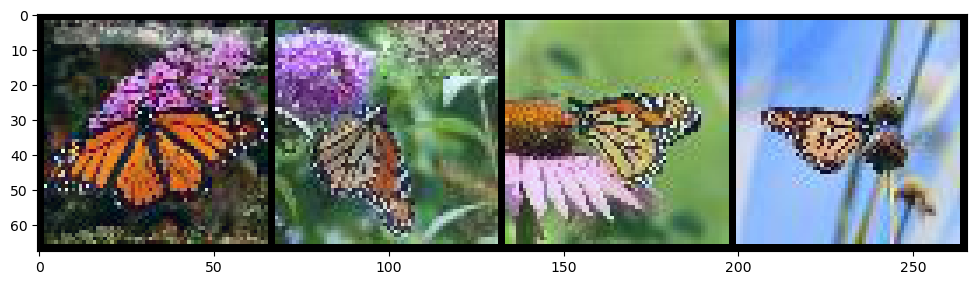

In [133]:
num = 4
base = torch.randint(0, 100000-num-1, (1,)).item()
word_labels = [label_dict[int(i)] for i in train_labels[base:base+4]]
print('base is ' + str(base))
print(word_labels[0])
img_select = train_images[base:base+num]
for i in range(num):
    img_min = img_select[i].min()
    img_max = img_select[i].max()
    img_select[i].clamp_(min=img_min, max=img_max)
    img_select[i].add_(-img_min).div_(img_max - img_min + 1e-5)
img = torchvision.utils.make_grid(img_select, nrow=num)
plt.figure(figsize=(12, 12))
plt.imshow(img.cpu().permute(1, 2, 0))

base is 78
espresso
pomegranate
abacus
sea slug, nudibranch



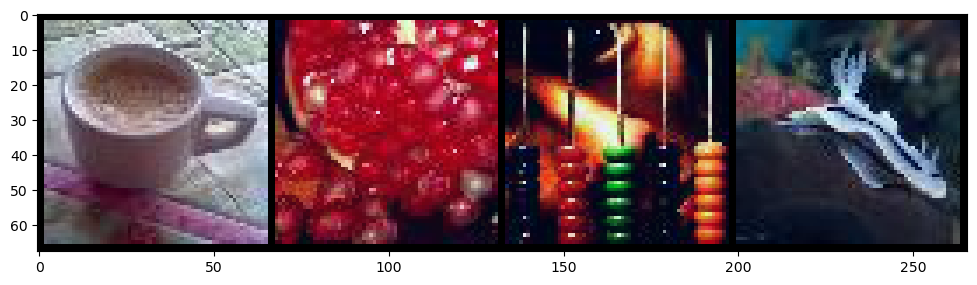

In [132]:
num = 4
base = torch.randint(0, 1000-num-1, (1,)).item()
word_labels = [label_dict[int(i)] for i in test_labels[base:base+4]]
print('base is ' + str(base))
label_str = ''
for item in word_labels:
    label_str += item + '\n'
print(label_str)
img_select = test_images[base:base+num]
for i in range(num):
    img_min = img_select[i].min()
    img_max = img_select[i].max()
    img_select[i].clamp_(min=img_min, max=img_max)
    img_select[i].add_(-img_min).div_(img_max - img_min + 1e-5)
img = torchvision.utils.make_grid(img_select, nrow=num)
plt.figure(figsize=(12, 12))
plt.imshow(img.cpu().permute(1, 2, 0))

In [129]:
def move_to_device(tensors, device):
    if type(tensors) is tuple:
        return tuple(tensor.to(device) for tensor in tensors)
    return tensors.to(device)

In [130]:
train_images, train_labels = move_to_device((train_images, train_labels), cuda)
test_images, test_labels = move_to_device((test_images, test_labels), cuda)

In [109]:
# find subset_domain and subset_labels
from torchmetrics.functional import pairwise_cosine_similarity

In [134]:
train_images.shape

torch.Size([100000, 3, 64, 64])

In [139]:
s0 = train_images.shape[0]
s1 = train_images.shape[1]
s2 = train_images.shape[2]
s3 = train_images.shape[3]
print(s2)

64


In [140]:
torch.flatten(train_images, start_dim=1).shape

torch.Size([100000, 12288])

In [146]:
def get_greedy_subset(domain, true_labels, num_points):
    inp_shape = list(domain.shape)[1:]
    subset_shape = [num_points] + inp_shape
    rand_index = torch.randint(0,len(domain), (1,)).item()
    subset_domain = torch.zeros(subset_shape, device=cuda)
    subset_labels = torch.zeros(num_points, dtype=torch.int64, device=cuda)
    subset_domain[0] = domain[rand_index]
    
    domain_flat = torch.flatten(domain, start_dim=1)
    for index in range(1, num_points):
        if index % 50 == 0:
            print(index)
        subset_domain_flat = torch.flatten(subset_domain[:index], start_dim=1)
        sim = pairwise_cosine_similarity(domain_flat, subset_domain_flat)
        max_sim = torch.max(sim, dim=1).values
        selected_index = torch.argmin(max_sim).item()
        subset_domain[index] = domain[selected_index]
        subset_labels[index] = true_labels[selected_index]
    return subset_domain, subset_labels    gi

In [147]:
greedy_train_images, greedy_train_labels = get_greedy_subset(train_images, train_labels, 5000)

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200


In [119]:
def get_greedy_class_subset(domain, true_labels, num_labels, num_points):
    #num_labels = len(torch.unique(true_labels))
    
    subset_domain_class = dict()
    for label in range(num_labels):
        sub_domain = domain[true_labels == label]
        subset_domain_class[label] = get_greedy_subset(sub_domain, num_points//num_labels)
    
    return subset_domain_class    

In [120]:
subset_domain_class = get_greedy_class_subset(domain, true_labels, 2, 100)

In [123]:
subset_domain_class[0].shape

torch.Size([50, 2])

In [130]:
subset_domain = get_greedy_subset(domain, 100)

In [132]:
torch.min(torch.max(pairwise_cosine_similarity(domain, subset_domain), dim=1).values).item()

0.9999046921730042

In [107]:
subset_labels[subset_labels == 1].shape

torch.Size([54])

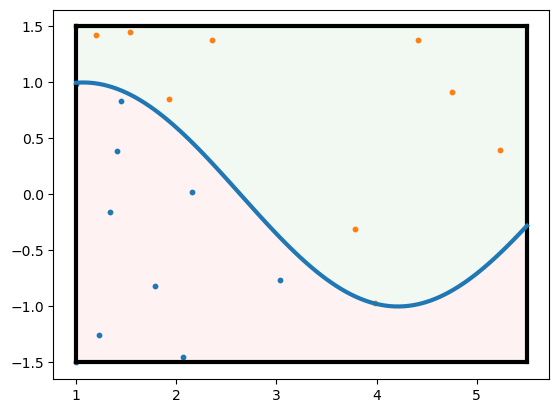

In [148]:
subset_domain_class = get_greedy_class_subset(domain, true_labels, 2, 20)


In [149]:
print(torch.min(torch.max(pairwise_cosine_similarity(domain[true_labels == 0], subset_domain_class[0]), dim=1).values).item())
print(torch.min(torch.max(pairwise_cosine_similarity(domain[true_labels == 1], subset_domain_class[1]), dim=1).values).item())

0.991810142993927
0.9935928583145142


In [135]:
subset_domain_class_labels = dict()
for k in subset_domain_class.keys():
    subset_domain_class_labels[k] = [k]*len(subset_domain_class[k])

In [11]:
def compute_unsafe_dir(reference_input, reference_label, selected_domain, selected_labels, classifier = None, beta=0.7):
    assert len(selected_domain) == len(selected_labels)
    
    unsafe_dirs = torch.zeros_like(selected_domain)
    unsafe_normalization = torch.ones(len(selected_domain), device=cuda)*float('inf')
    
    for (index, input) in enumerate(selected_domain):
        norm_diff = torch.linalg.norm(input - reference_input, ord=2)
        unsafe_dirs[index] = (input-reference_input)/norm_diff
            
        if selected_labels[index] != reference_label:
            if classifier is not None: 
                # binary search to compute normalization when the true labeling function is given
                low = 0
                high = 1
                while high - low > 1e-5:
                    alpha = (high + low)/2
                    input_alpha = reference_input + alpha*(input-reference_input)
                    label_alpha = predict_label(classifier, input_alpha)
                    if label_alpha == reference_label:
                        low = alpha
                    else:
                        high = alpha
                alpha = low
                input_alpha = reference_input + alpha*(input-reference_input)
                unsafe_normalization[index] = torch.linalg.norm(input_alpha-reference_input, ord=2)
            else:
                unsafe_normalization[index] = norm_diff*beta 
    
    return unsafe_dirs, unsafe_normalization

In [188]:
cpu = torch.device("cpu")
cpu

device(type='cpu')

In [190]:
a = torch.randn(2,device=cuda)
print(a)
a.get_device()

tensor([ 0.6436, -0.9408], device='cuda:0')


0

In [193]:
b = a.to(device=cpu)
print(b)
b.get_device()

tensor([ 0.6436, -0.9408])


-1

In [187]:
a

tensor([-0.6272, -0.1831], device='cuda:0')

In [179]:
a = float('inf')
a = torch.randn(2,device=cuda)
a.to_device('cpu')

tensor([ 1.2774, -0.3040], device='cuda:0')

In [183]:
b = torch.randn(2)
b.get_device()

-1

In [194]:
def non_isotropic_dist(unsafe_dir, unsafe_normalization, perturbation, dist_type='PL', return_device='cpu', return_type=None):
    if dist_type not in ['PL', 'PD', 'WD']:
        raise ValueError('Non-isotropic distance type should be one of PL, PD, WD')
    
    distance = float('inf')
    
    element_wise_mul = torch.mul(unsafe_dir, perturbation)
    
    if dist_type == 'PL' or dist_type == 'PD':
        scaled_projections = torch.div(torch.sum(element_wise_mul, dim=1), unsafe_normalization)
        if dist_type == 'PL':
            distance = torch.max(scaled_projections)
        elif dist_type == 'PD':
            distance = torch.max(torch.abs(scaled_projections))
    
    if dist_type == 'WD':
        unsafe_4_norm = torch.linalg.norm(unsafe_dir, dim=1, ord=4)**2 # 4-norm
        modified_normalization = torch.mul(unsafe_normalization, unsafe_4_norm)
        scaled_distances = torch.div(torch.linalg.norm(element_wise_mul, dim=1, ord=2), modified_normalization)
        distance = torch.max(scaled_distances)
    
    distance = distance.detach().to(device=return_device)
    
    if return_type is not None:
        return distance.numpy()
    else:
        return distance

In [ ]:
def non_isotropic_projection(unsafe_dir, unsafe_normalization, perturbation, epsilon=1.0, dist_type='PL', num_rounds=3):
    if dist_type not in ['PL', 'PD', 'WD']:
        raise ValueError('Non-isotropic distance type should be one of PL, PD, WD')
    
    if dist_type == 'WD':
        raise ValueError('Projection onto WD currently unsupported')
    
    device = perturbation.get_device()
    scale_flag = False 
    current_perturbation = perturbation 
    
    for t in range(len(num_rounds)):
        for (u, M) in zip(unsafe_dir, unsafe_normalization):
            if dist_type == 'PL' or dist_type == 'PD':
                distance = torch.sum(torch.mul(u, current_perturbation))/M 
                current_perturbation = current_perturbation - (distance-epsilon)*u
                if dist_type == 'PD':
                    distance = torch.sum(torch.mul(-u, current_perturbation))/M
                    current_perturbation = current_perturbation - (distance-epsilon)*(-u)
            else:
                continue 
        
        distance = non_isotropic_dist(unsafe_dir, unsafe_normalization, current_perturbation, dist_type=dist_type, return_device=device, return_type=None)
        if distance <= epsilon:
            break 
    
    distance = non_isotropic_dist(unsafe_dir, unsafe_normalization, current_perturbation, dist_type=dist_type, return_device=device, return_type=None)
    
    if distance > epsilon:
        scale_flag = True
        current_perturbation *= (epsilon/distance)
    
    return current_perturbation, scale_flag

In [13]:
distance_types = ['l2', 'l1', 'linf', 'PL', 'PD', 'WD']

In [14]:
def latexify_dist(dist_type: str):
    if dist_type == 'l2': return r'$\ell_2$'
    elif dist_type == 'linf': return r'$\ell_{\infty}$'
    elif dist_type == 'l1': return r'$\ell_1$'
    else: return dist_type

def latexify_inp(index: int):
    if index == 0: return r'$x$'
    elif index == 1: return r'$x_1$'
    elif index == 2: return r'$x_2$'
    elif index == 3: return r'$\tilde{x}$'
    
def latexify_h(index):
    if index is None: return r'$h^{\star}$'
    elif index == 1: return r'$h_1$'
    elif index == 2: return r'$h_2$'

In [168]:
def get_distances(reference_input, reference_label, domain, true_labels, selected_domain = None, selected_labels = None, classifier = None, dist_type='l2'):
    print("Computing " + dist_type + " distances")
    if dist_type not in distance_types:
        raise ValueError('Distance type should be one of l2, l1, linf, PL, PD, WD')
    
    if selected_domain is not None and selected_labels is not None:
        assert len(selected_domain) == len(selected_labels)
        unsafe_dir, unsafe_normalization = compute_unsafe_dir(reference_input, reference_label, selected_domain, selected_labels, classifier=classifier)
    else:
        unsafe_dir, unsafe_normalization = compute_unsafe_dir(reference_input, reference_label, domain, true_labels, classifier=classifier)        
    
    distances = []
    for (index, input) in enumerate(domain):
        if index % 100 == 0:
            clear_output(wait=True)
            print("Computing distances at index: " + str(index) +  ", out of " + str(len(domain) - 1) + " points.")
        perturbation = input - reference_input
        if dist_type == 'l2':
            distance = torch.linalg.norm(perturbation, ord=2).detach().cpu().numpy()
        elif dist_type == 'l1':
            distance = torch.linalg.norm(perturbation, ord=1).detach().cpu().numpy()
        elif dist_type == 'linf':
            distance = torch.linalg.norm(perturbation, ord=float('inf')).detach().cpu().numpy()
        elif dist_type in ['PL', 'PD', 'WD']:
            distance = non_isotropic_dist(unsafe_dir, unsafe_normalization, perturbation, dist_type)
        distances.append(distance)
    return distances

def sublevel_set(selected_domain, distances, threshold):
    sublevel = []
    for input, distance in zip(selected_domain, distances):
        if distance <= threshold:
            sublevel.append(input.detach().cpu().numpy())
    return sublevel

In [140]:
l_keys = subset_domain_class.keys()
print(len(l_keys))

2


In [142]:
l_keys_list = list(l_keys)

In [144]:
l_keys_list[0]

0

In [143]:
subset_domain_class[l_keys_list[0]].shape

torch.Size([50, 2])

In [145]:
for i in range(2):
    print(i)

0
1


In [169]:
def generate_distances(reference_domain, reference_labels, domain, true_labels, classifier=h_star, distance_types=distance_types, greedy_subset=False, num_points=100):
    selected_domain = None 
    selected_labels = None 
    
    if greedy_subset:
        num_labels = len(torch.unique(true_labels))
        subset_domain_class = get_greedy_class_subset(domain, true_labels, num_labels, num_points)
        inp_shape = list(domain.shape)[1:]
        selected_domain_shape = [num_points] + inp_shape
        selected_domain = torch.zeros(selected_domain_shape, device=cuda)
        selected_labels = torch.ones(num_points, device=cuda)
        label_keys = list(subset_domain_class.keys())
        increment = num_points//num_labels
        for label_index in range(len(label_keys)):
            selected_domain[label_index*increment:(label_index+1)*increment] = subset_domain_class[label_keys[label_index]]
            selected_labels[label_index*increment:(label_index+1)*increment] *= label_keys[label_index]

    distances = dict()
    for dist_type in distance_types:
        if greedy_subset and dist_type not in ['PL', 'PD', 'WD']:
            continue 
                
        for index in range(len(reference_domain)):
            key = "x" + str(index) + "_" + dist_type
            if greedy_subset:
                key += "_greedy_" + str(num_points)
            
            distances[key] = get_distances(reference_domain[index], reference_labels[index], domain, true_labels, selected_domain=selected_domain, selected_labels=selected_labels, classifier=classifier, dist_type=dist_type)
    
    return distances, selected_domain, selected_labels        

In [170]:
greedy_distances, selected_domain, selected_labels = generate_distances(reference_domain, reference_labels, domain, true_labels, greedy_subset=True, num_points=20)

Computing distances at index: 39900, out of 39999 points.


In [171]:
greedy_distances.keys()

dict_keys(['x0_PL_greedy_20', 'x1_PL_greedy_20', 'x2_PL_greedy_20', 'x3_PL_greedy_20', 'x0_PD_greedy_20', 'x1_PD_greedy_20', 'x2_PD_greedy_20', 'x3_PD_greedy_20', 'x0_WD_greedy_20', 'x1_WD_greedy_20', 'x2_WD_greedy_20', 'x3_WD_greedy_20'])

In [176]:
def plot_distance_intensity(corners, reference_points, distances, domain, selected_domain=None, distance_types=distance_types, greedy_subset=False, num_points=100):
    x0, x1, x2, xtil = reference_points[0], reference_points[1], reference_points[2], reference_points[3]
    x_left, y_left, x_right, y_right, x_down, y_down, x_up, y_up = generate_data_domain(corners)
    x, y_star, y_1, y_2 = generate_decision_boundary(corners)
    
    domain_np = domain.cpu().numpy()
    domain_x = [d[0] for d in domain_np]
    domain_y = [d[1] for d in domain_np]
    
    for dist_type in distance_types:
        if greedy_subset and dist_type not in ['PL', 'PD', 'WD']:
            continue 
        
        for index in range(len(reference_points)):
            key = "x" + str(index) + "_" + dist_type
            if greedy_subset:
                key += "_greedy_" + str(num_points)
            
            distance_domain = distances[key]
            plt.figure()
            title_str = latexify_dist(dist_type) + " threat "
            title_str += " from reference point " + latexify_inp(index)
            plt.title(title_str)
            
            # plot the data domain
            plt.plot(x_left, y_left, color="black", linewidth=3)
            plt.plot(x_right, y_right, color="black", linewidth=3)
            plt.plot(x_down, y_down, color="black", linewidth=3)
            plt.plot(x_up, y_up, color="black", linewidth=3)
    
            # plot true labeling decision boundary 
            plt.plot(x, y_star, label=r'$h^{\star}$', linewidth=3)
        
            # plot reference points
            plt.plot(x0[0], x0[1], color="black", marker=latexify_inp(0), markersize=9)
            plt.plot(x1[0], x1[1], color="black", marker=latexify_inp(1), markersize=12)
            plt.plot(x2[0], x2[1], color="black", marker=latexify_inp(2), markersize=12)
            plt.plot(xtil[0], xtil[1], color='black', marker=latexify_inp(3), markersize=12)
            
            # Plot the distance intensity map
            plt.scatter(domain_x, domain_y, c=distance_domain, s=2, cmap="plasma")
            plt.colorbar(orientation='horizontal')
            
            if selected_domain is not None:
                selected_np = selected_domain.cpu().numpy()
                selected_x = [d[0] for d in selected_np]
                selected_y = [d[1] for d in selected_np]
                plt.scatter(selected_x, selected_y, color="black", s=5)
    
            
            plt.axis('off')
            plt.savefig("./distance_intensity_" + key + ".pdf", bbox_inches='tight')

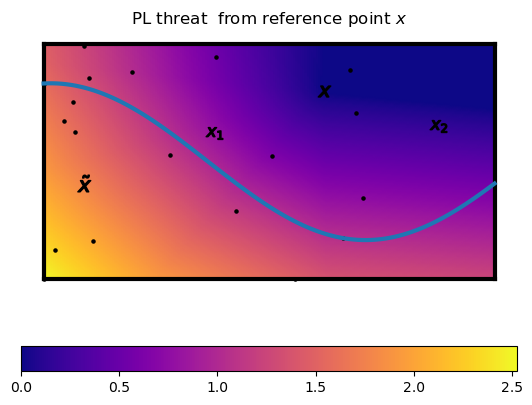

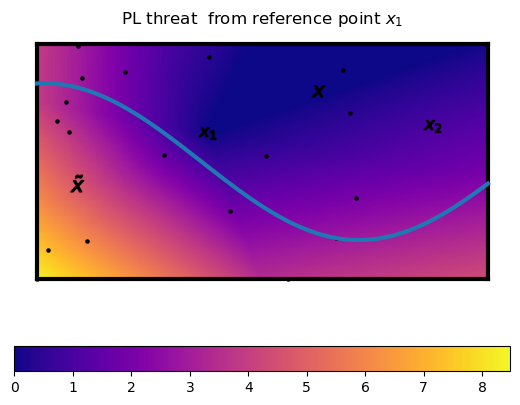

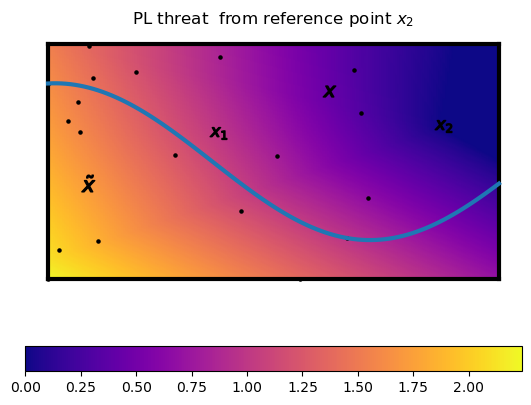

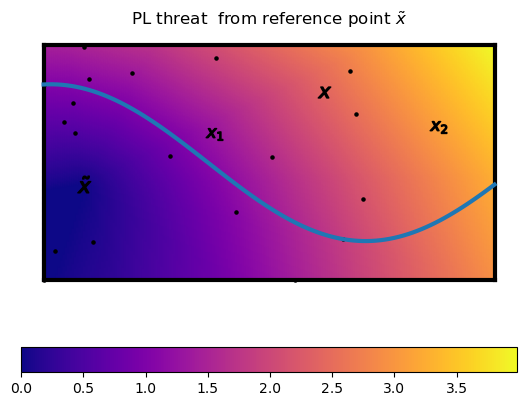

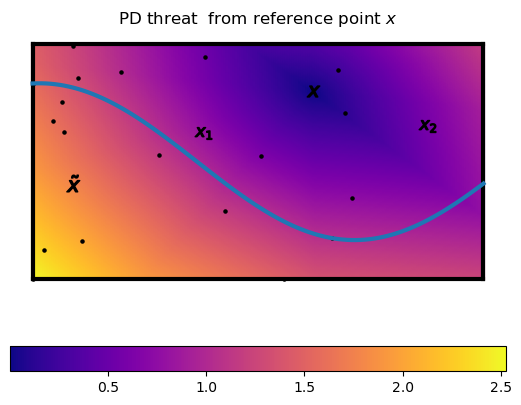

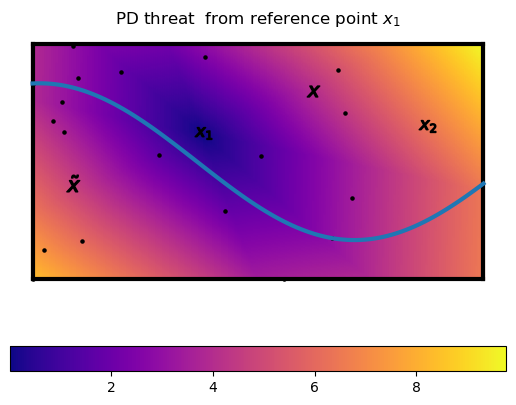

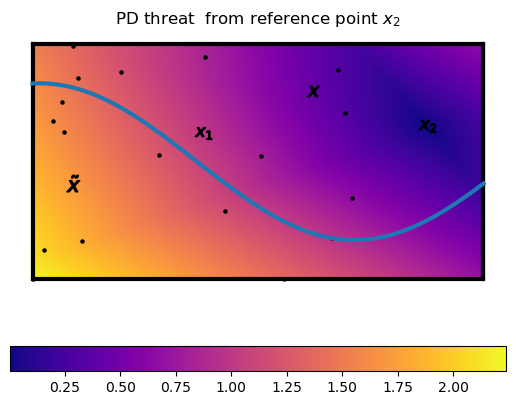

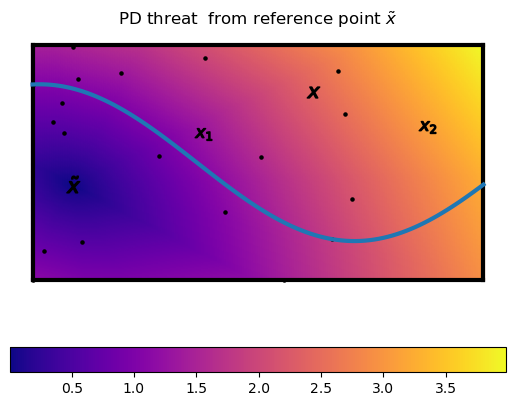

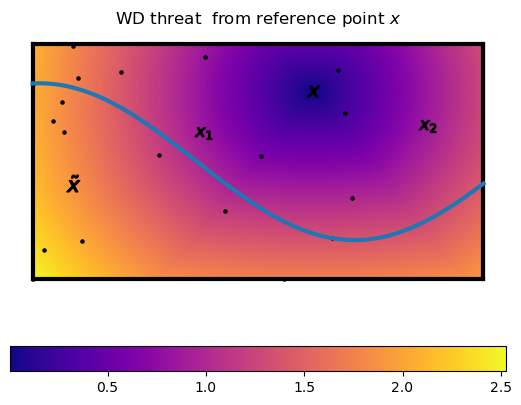

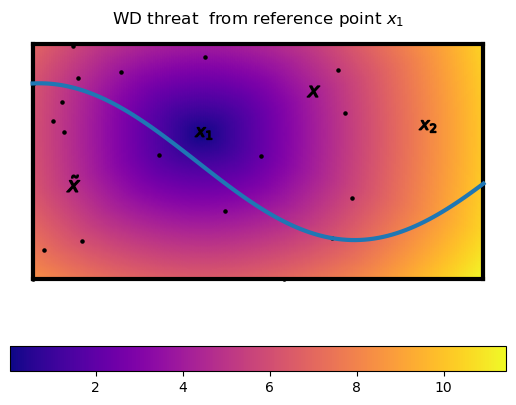

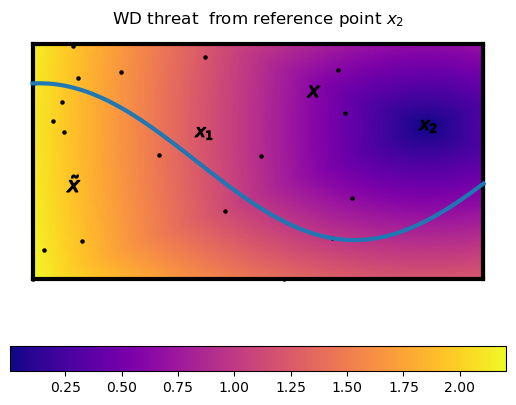

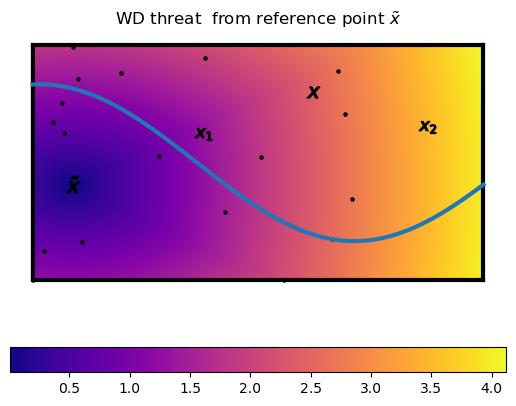

In [177]:
plot_distance_intensity(corners, reference_points, greedy_distances, domain, selected_domain=selected_domain, greedy_subset=True, num_points=20)   

In [197]:
# Compute certified threshold for a given point based on its distances matrix and the collection of all points. 
def compute_certified_threshold(reference_domain, reference_labels, domain, true_labels, distances):
    certified_thresholds = dict()
    for dist_type in distance_types:
        for r_index in range(len(reference_domain)):
            key = "x" + str(r_index) + "_" + dist_type
            reference_label = reference_labels[r_index]
            threshold = float('inf')
            for index in range(len(domain)):
                if true_labels[index] != reference_label and threshold > distances[key][index]:
                    threshold = distances[key][index]
            certified_thresholds[key] = threshold
    return certified_thresholds

In [198]:
reference_labels_h1 = predict_label(h_1, reference_domain)
reference_labels_h2 = predict_label(h_2, reference_domain)

domain_labels_h1 = predict_label(h_1, domain)
domain_labels_h2 = predict_label(h_2, domain)

certified_thresholds_hstar = compute_certified_threshold(reference_domain, reference_labels, domain, true_labels, distances)
certified_thresholds_h1 = compute_certified_threshold(reference_domain, reference_labels_h1, domain, domain_labels_h1, distances)
certified_thresholds_h2 = compute_certified_threshold(reference_domain, reference_labels_h2, domain, domain_labels_h2, distances)

In [210]:
str(certified_thresholds_hstar['x0_PL'])

'1.0008105'

In [212]:
latexify_h(None)

'$h^{\\star}$'

In [213]:
latexify_dist('l2')

'$\\ell_2$'

In [217]:
latexify_inp(0)

'$x$'

In [225]:
def plot_sublevel_sets(corners, reference_points, distances, domain, certified_thresholds, distance_types=distance_types, h_index=None):
    x0, x1, x2, xtil = reference_points[0], reference_points[1], reference_points[2], reference_points[3]
    x_left, y_left, x_right, y_right, x_down, y_down, x_up, y_up = generate_data_domain(corners)
    x, y_star, y_1, y_2 = generate_decision_boundary(corners)
    h_str = "h" + str(h_index) if h_index is not None else "hstar"
            
    domain_np = domain.cpu().numpy()
    domain_x = [d[0] for d in domain_np]
    domain_y = [d[1] for d in domain_np]
    
    for dist_type in distance_types:
        for index in range(len(reference_points)):
            key = "x" + str(index) + "_" + dist_type
            distance_domain = distances[key]
            certified_threshold = certified_thresholds[key]
            cert_str = "%.2f" % certified_threshold 
            title_str = latexify_dist(dist_type) + " certified threshold for " + latexify_h(h_index) + " at " + latexify_inp(index) + " is " + cert_str
            plt.figure()
            plt.title(title_str)
            
            # plot the data domain
            plt.plot(x_left, y_left, color="black", linewidth=3)
            plt.plot(x_right, y_right, color="black", linewidth=3)
            plt.plot(x_down, y_down, color="black", linewidth=3)
            plt.plot(x_up, y_up, color="black", linewidth=3)
    
            # plot true labeling decision boundary 
            plt.plot(x, y_star, label=r'$h^{\star}$', linewidth=3)
            
            if h_index == 1:
                plt.plot(x, y_1, color='magenta', label=latexify(h_index), linestyle="dashed")
                plt.fill_between(x, y1=y_1, y2=y_star, color= "magenta", alpha= 0.05, hatch='///')
            elif h_index == 2:
                plt.plot(x, y_2, color='purple', label=latexify(h_index), linestyle="dashed")
                plt.fill_between(x, y1=y_2, y2=y_star, color= "purple", alpha= 0.05, hatch='///')
    
            # plot reference points
            plt.plot(x0[0], x0[1], color="black", marker=r"$x$", markersize=9)
            plt.plot(x1[0], x1[1], color="black", marker=r"$x_1$", markersize=12)
            plt.plot(x2[0], x2[1], color="black", marker=r"$x_2$", markersize=12)
            plt.plot(xtil[0], xtil[1], color='black', marker=r'$\tilde{x}$', markersize=12)
            
            # Plot the sublevel sets upto certified threshold
            epsilons = np.linspace(0, certified_threshold, 5)
            for eps in epsilons: 
                sublevel = sublevel_set(domain, distance_domain, eps)
                sublevel_x = [d[0] for d in sublevel]
                sublevel_y = [d[1] for d in sublevel]
                plt.scatter(sublevel_x, sublevel_y, c='red', s=0.1/(0.1+eps))

            plt.axis('off')
            plt.savefig("./certified threshold_" + h_str + key + ".pdf", bbox_inches='tight')



In [ ]:
plot_sublevel_sets(corners, reference_points, distances, domain, certified_thresholds_hstar, h_index=None)

plot_sublevel_sets(corners, reference_points, distances, domain, certified_thresholds_h1, h_index=1)

plot_sublevel_sets(corners, reference_points, distances, domain, certified_thresholds_h2, h_index=2)
    

In [ ]:
# unsafe_dir, unsafe_normalization = compute_unsafe_dir(p_ref, domain)
# unsafe_pert = []
# for d in unsafe_dir:
#     unsafe_pert.append(sum(p_ref, d))

# unsafe_pert_x = [d.x for d in unsafe_pert]
# unsafe_pert_y = [d.y for d in unsafe_pert]


# sublevel_PL = sublevel_set(domain, distance_domain_PL, 0.0)

# sublevel_PL_x = [d.x for d in sublevel_PL]
# sublevel_PL_y = [d.y for d in sublevel_PL]


# plt.scatter(sublevel_PL_x, sublevel_PL_y, c='green', s=0.1)
# plt.scatter(unsafe_pert_x, unsafe_pert_y, c='red', s=0.1)
# #plt.plot([3.8],[0.9], color='black', marker=r'$x$', markersize=9)
# #plt.plot([2.7],[0.361], color='red', marker=r'$x_1$', markersize=12)
# #plt.plot([1.4],[-0.276], color='red', marker=r'$\tilde{x}$', markersize=12)
# plt.plot([4.94],[0.452], color='red', marker=r'$x_2$', markersize=12)
# plt.plot(x, y, color="black", label="h*", linewidth=3)
# plt.plot(x1,y1, color="black", linewidth=3)
# plt.plot(x2,y2, color="black", linewidth=3)
# plt.plot(x3,y3, color="black", linewidth=3)
# plt.plot(x4,y4, color="black", linewidth=3)
# plt.axis('off')
# plt.title("x + Unsafe Directions")

In [1]:
checking auth. 

SyntaxError: invalid syntax (2074398531.py, line 1)

# Things to do

## CodeBase 
- 

## Code Refactor 
- Convert point class to torch vector and have functionality that tensors converts to numpy arrays (and check devices) for plotting 
- Modularize existing code to print all relevant plots and save relevant figures (sublevel sets at p0,p1,p2, p-til)
- Save the data domain as a data set. with a tag of "exact partition"
- Add data-generator code that fixes and samples from grid when asked for "synthetic2D"
- Add data-generator code that does regular data-loading for "MNIST, BlockMNIST, CIFAR-x, Imagenet"
- Add dataset-hyperparams for each. 

## Threat functions 
- Implement isotropic functions
- For each point, compute unsafe directions and exact normalization. 
- Implement non-isotropic threat functions. 

## Synthetic2D
- Choose synthetic h, h1, h2 and data domain. 
- Visualize data domain with points p0, p1, p2 and ptil. 
- Design class-wise marginal input distribution that are tightly concentrated. Sample 500 points for each label. 
- Find certified radius for each triple (h, x, d) w.r.t each d in distance metrics (N, approx-n, k-approx-N), each x in the data domain, and h in {h*, h1,h2} by searching over sublevel sets. 
- Visualize as intensity maps. Show variation between h1 and h2. 

## Observed and k-Observed
- Compute unsafe directions with beta normalization w.r.t all sample points. Add resulting distances as observed-PL. 
- Given any data-set find k-subsets for each class using greedy approximation of cosine similarity. Add resulting distances as k-observed-PL. 
- Choose beta for normalization based on the minimal norm of all observed unsafe directions that are within a kappa threshold in cosine similarity. 
- Run through visualization and certification sequence for PL (if exact), observed-PL and k-observed-PL. 

## Projection
- Given a reference point pref, a new point p, Find projection of p to sublevel set Td(pref, epsilon). 
- Use greedy projection algorithm for each non-isotropic distance. Run T rounds and then scale the iterate if it is still not in the sublevel set. 

## Augment
- N-Mixup 
- N-Project
- Visualize points added according to both on the "synthetic2D" dataset. 

## Attack and Train
- N-PGD : Generic PGD + projection onto C set where C is specific by a N-threat function or just a simple threat function. 
- Adversarial training with N-PGD. 
- Robust Accuracy evaluation. 
- Learn tiny neural network on synthetic2D. show N-PGD attack points. 

## SOTA Evaluation
- Import model weights from RobustBench and plug into existing code-base. 
- Compute robust accuracy under PGD and N-PGD attacks. Show ranking and robust accuracy curves. 
- Finetune top-5 models with N-Mixup, N-Project and N-adversarial training, show robust accuracy on all combinations and hyperparameter sweeps. 


## Certified Robustness  
- Search over approximation of predictor intensity based on LirPA, plot histograms and certified accuracy curves. 
